In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import head_direction.head as head
import spatial_maps as sp
import speed_cells.speed as spd
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from distutils.dir_util import copy_tree
from neo import SpikeTrain
import scipy

from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

from spike_statistics.core import permutation_resampling

from spikewaveform.core import calculate_waveform_features_from_template, cluster_waveform_features

from septum_mec.analysis.plotting import violinplot

19:18:12 [I] klustakwik KlustaKwik2 version 0.2.6


In [3]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 4), 
    'figure.dpi': 150
})

output_path = pathlib.Path("output") / "stimulus-response"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)
output_path.mkdir(exist_ok=True)

In [4]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [5]:
identification_action = actions['identify-neurons']
sessions = pd.read_csv(identification_action.data_path('sessions'))
units = pd.read_csv(identification_action.data_path('units'))
session_units = pd.merge(sessions, units, on='action')

In [6]:
stim_action = actions['stimulus-response']
stim_results = pd.read_csv(stim_action.data_path('results'))

In [9]:
# lfp_results has old unit id's but correct on (action, unit_name, channel_group)
stim_results = stim_results.drop('unit_id', axis=1)

In [7]:
statistics_action = actions['calculate-statistics']
shuffling = actions['shuffling']

statistics_results = pd.read_csv(statistics_action.data_path('results'))
statistics_results = session_units.merge(statistics_results, how='left')
quantiles_95 = pd.read_csv(shuffling.data_path('quantiles_95'))
action_columns = ['action', 'channel_group', 'unit_name']
data = pd.merge(statistics_results, quantiles_95, on=action_columns, suffixes=("", "_threshold"))

In [8]:
data['unit_day'] = data.apply(lambda x: str(x.unit_idnum) + '_' + x.action.split('-')[1], axis=1)

In [10]:
data = data.merge(stim_results, how='left')

In [11]:
waveform_action = actions['waveform-analysis']
waveform_results = pd.read_csv(waveform_action.data_path('results')).drop('template', axis=1)

In [12]:
data = data.merge(waveform_results, how='left')

In [13]:
colors = ['#d95f02','#e7298a']
labels = ['11 Hz', '30 HZ']
queries = ['frequency==11', 'frequency==30']

In [14]:
data.bs = data.bs.astype(bool)

In [15]:
grid_query = 'gridness > gridness_threshold and information_rate > information_rate_threshold'
gridcell_sessions = data.query(grid_query)
print("Number of gridcells", len(gridcell_sessions))
# print("Number of animals", len(gridcell_sessions.groupby(['entity'])))

Number of gridcells 225


In [22]:
data['gridcell'] = data.isin(data.query(grid_query))

In [23]:
data.query('baseline and gridcell')

action  channel_group  unit_name  average_rate  speed_score  \
32    1833-260619-1              0        118      5.946164     0.169495   
34    1833-260619-1              0        130      2.860363     0.081075   
35    1833-260619-1              0        132      3.366046     0.072301   
39    1833-260619-1              1        116     17.473449     0.193373   
40    1833-260619-1              1        126      5.892390     0.183633   
42    1833-260619-1              3        114     13.438331     0.224642   
43    1833-260619-1              5        100     17.448630     0.144593   
45    1833-260619-1              6        102     10.841667     0.235736   
48    1833-260619-1              6        112      5.891356     0.226892   
49    1833-260619-1              6        124      7.915120     0.182376   
57    1834-150319-3              3         61     17.163920     0.021890   
124   1833-010719-1              1        219      2.868256     0.170572   
125   1833-010719-1              1        221      6.912671     0.090486   
126   1833-010719-1              1        229      4.230245     0.018811   
128   1833-010719-1              1          8     16.737459     0.254297   
129   1833-010719-1              2        202     25.977054     0.226032   
131   1833-010719-1              3        171     14.687550     0.163959   
132   1833-010719-1              3        198     18.659249     0.282318   
134   1833-010719-1              3        240      3.107182     0.076765   
135   1833-010719-1              5        134      6.214363     0.168450   
136   1833-010719-1              5        144      2.226506     0.119543   
209   1833-050619-1              2         99      3.350056     0.095012   
214   1833-050619-1              6         60      7.177620     0.259306   
215   1833-050619-1              6         64     16.944449     0.243525   
216   1833-050619-1              6         91      3.325889     0.155904   
221   1833-060619-1              4        172      2.654829     0.119661   
223   1833-060619-1              5        164      3.083686     0.021853   
227   1833-060619-1              6        170      3.080462     0.155454   
262   1834-150319-1              3         95     19.609185     0.063354   
274   1839-120619-1              5        158     12.579822     0.285708   
...             ...            ...        ...           ...          ...   
1130  1834-010319-4              0          7     18.428099     0.073675   
1151  1833-200619-1              4        165      4.093726     0.112030   
1152  1833-200619-1              6        163     17.705502     0.202908   
1153  1833-200619-1              6        171      4.061107     0.058014   
1154  1833-200619-1              6        206      3.982277     0.150630   
1155  1833-200619-1              6        240      4.089649     0.098818   
1156  1833-200619-1              7        143      9.300587     0.218310   
1162  1839-120619-3              5        131     17.773050     0.076020   
1165  1839-120619-3              6        133      2.612293     0.053873   
1167  1839-120619-3              7        119      4.950355     0.132893   
1168  1839-120619-3              7        127      5.407801     0.091931   
1199  1833-260619-3              0        140      3.564682     0.063184   
1200  1833-260619-3              0        141      2.694224     0.094154   
1202  1833-260619-3              0        182      5.289030     0.148720   
1203  1833-260619-3              0        194      6.485358     0.096207   
1205  1833-260619-3              0        209      3.425497     0.085117   
1207  1833-260619-3              1        170     26.841716     0.218178   
1208  1833-260619-3              1        207      4.589791     0.088439   
1211  1833-260619-3              3        176      7.407735     0.156101   
1213  1833-260619-3              5        111      9.222663     0.179913   
1216  1833-260619-3              6        142      9.359639  

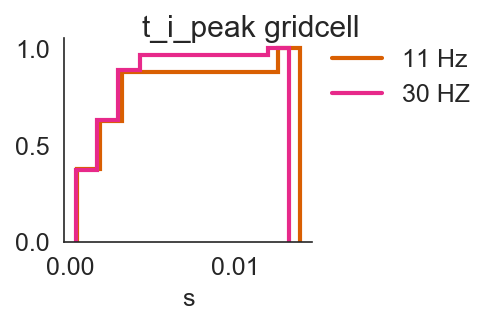

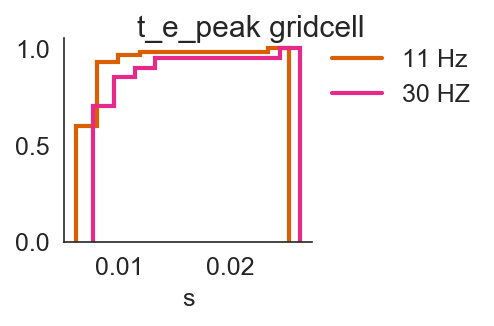

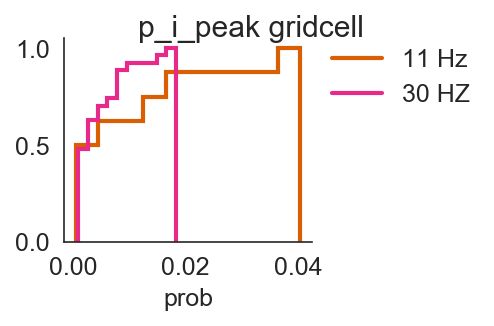

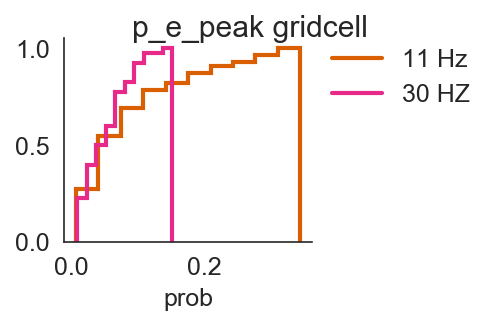

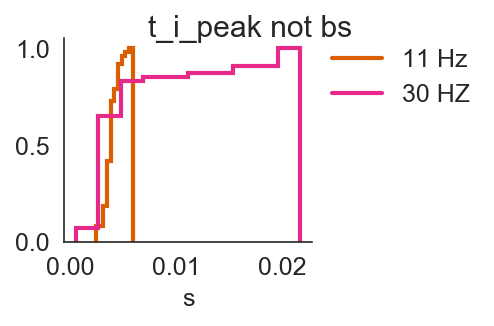

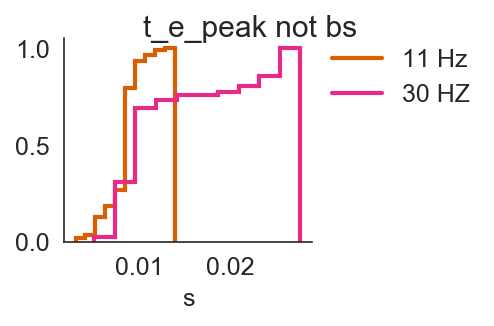

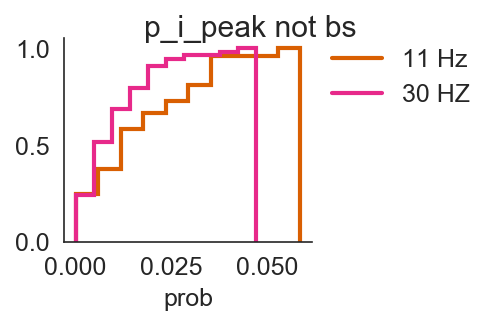

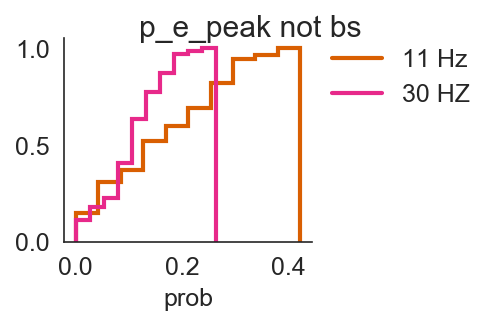

In [61]:

density = True
cumulative = True
histtype = 'step'
lw = 2
bins = {
    't_i_peak': None,
    't_e_peak': None,
    'p_i_peak': None,
    'p_e_peak': None,
}
xlabel = {
    't_i_peak': 's',
    't_e_peak': 's',
    'p_i_peak': 'prob',
    'p_e_peak': 'prob',
}

for cell_type in ['gridcell', 'not bs']:
    for key in bins:
        fig = plt.figure(figsize=(3.5,2.2))
        plt.suptitle(key + ' ' + cell_type)
        legend_lines = []
        for color, query, label in zip(colors, queries, labels):
            data.query(query + ' and ' + cell_type)[key].hist(
                bins=bins[key], density=density, cumulative=cumulative, lw=lw, 
                histtype=histtype, color=color)
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, lw=lw, label=label))
        plt.xlabel(xlabel[key])
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
        plt.grid(False)
#         plt.xlim(-0.05, bins[key].max() - bins[key].max()*0.02)
        sns.despine()
        figname = f'histogram-{key}-{cell_type}'.replace(' ', '-')
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)

In [30]:
from septum_mec.analysis.plotting import plot_bootstrap_timeseries

In [26]:
psth = pd.read_feather(output_path / 'data' / 'psth.feather')
times = pd.read_feather(output_path / 'data' / 'times.feather')

In [28]:
times = times.T.iloc[0].values

In [62]:
cs = ['#d95f02', '#e7298a', '#993404', '#980043']
lb = ['GC 11 Hz', 'GC 30 Hz', 'NS 11 Hz', 'NS 30 Hz']

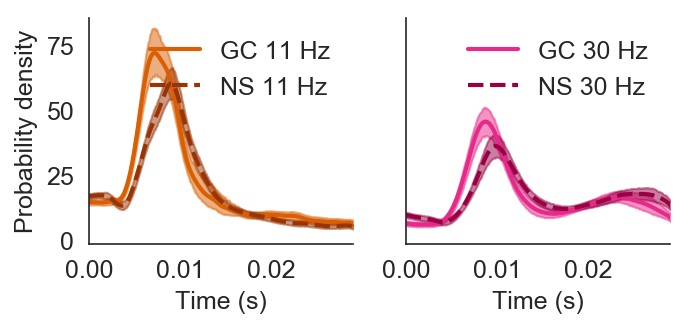

In [64]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(5,2))
ii = 0
for cell_type, ls in zip(['gridcell', 'not bs'], ['-', '--']):
    for i, (ax, query) in enumerate(zip(axs.ravel(), queries)):
        selection = [
            f'{r.action}_{r.channel_group}_{r.unit_name}' 
            for i, r in data.query(query + ' and ' + cell_type).iterrows()]
        values = psth.loc[:, selection].dropna(axis=1).to_numpy()

        plot_bootstrap_timeseries(times, values, ax=ax, lw=2, label=lb[ii], color=cs[ii], ls=ls)
    #     ax.set_title(titles[i])
        ax.set_xlabel('Time (s)')
        ax.legend(frameon=False)
        ii += 1
    axs[0].set_ylabel('Probability density')
    sns.despine()
    plt.xlim(0, 0.029)
    
figname = f'response-probability'
fig.savefig(
    output_path / 'figures' / f'{figname}.png', 
    bbox_inches='tight', transparent=True)
fig.savefig(
    output_path / 'figures' / f'{figname}.svg', 
    bbox_inches='tight', transparent=True)

# Store results in Expipe action

In [144]:
action = project.require_action("stimulus-response")